Created on Thu Apr 18 05:43:21 2024

@author: Santiago D'hers

Use:

- This script will compare the performance of different trained models

Requirements:

- Models trained with 3a-Create_Models.py
- Access to the file colabeled_data.csv, where we can find:
    - Position and labels for representative exploration events
    - It includes the labels of 5 viewers (so far)

In [54]:
import h5py
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
import random
import datetime

import joblib

# from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, classification_report, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from keras.models import load_model

import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

print(tf.config.list_physical_devices('GPU'))

[]


In [55]:
desktop = 'C:/Users/dhers/Desktop'
STORM_folder = os.path.join(desktop, 'STORM/models')

colabels_file = os.path.join(STORM_folder, 'colabels.csv')
colabels = pd.read_csv(colabels_file)

frames = 7

today = datetime.datetime.now()
# use_model_date = today.date()
use_model_date = '2024-10-23'

objects = ['obj']
bodyparts = ['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body']

In [56]:
def recenter(df, point, bodyparts=['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body']):
    # Create a copy of the original dataframe
    df_copy = df.copy()
    bodypart_columns = []
    
    for bodypart in bodyparts:
        # Subtract point_x from columns ending in _x
        x_cols = [col for col in df_copy.columns if col.endswith(f'{bodypart}_x')]
        df_copy[x_cols] = df_copy[x_cols].apply(lambda col: col - df_copy[f'{point}_x'])
        
        # Subtract point_y from columns ending in _y
        y_cols = [col for col in df_copy.columns if col.endswith(f'{bodypart}_y')]
        df_copy[y_cols] = df_copy[y_cols].apply(lambda col: col - df_copy[f'{point}_y'])
        
        # Collect bodypart columns
        bodypart_columns.extend(x_cols)
        bodypart_columns.extend(y_cols)
        
    return df_copy[bodypart_columns]

In [57]:
def reshape(df):
    reshaped_df = []
    
    # Iterate over each row index in the DataFrame
    for i in range(len(df)):
        # Determine which indices to include for reshaping
        indices_to_include = [
            max(0, i - 6),  # i - 6, ensure it's not negative
            max(0, i - 3),  # i - 3, ensure it's not negative
            max(0, i - 1),  # i - 1, ensure it's not negative
            i,              # current index
            min(len(df) - 1, i + 1),  # i + 1, ensure it's not out of bounds
            min(len(df) - 1, i + 3),  # i + 3, ensure it's not out of bounds
            min(len(df) - 1, i + 6)   # i + 6, ensure it's not out of bounds
        ]
        
        # Append the rows using the calculated indices
        reshaped_df.append(df.iloc[indices_to_include])
    
    return reshaped_df

In [58]:
def create_chimera(df, n_cols=5):

    # Randomly select a column index (0 to cols_to_use-1) for each row
    chosen_indices = np.random.randint(0, n_cols, size=len(df))

    # Use numpy to get the values of the randomly chosen columns
    chimera_values = df.values[np.arange(len(df)), chosen_indices]

    # Calculate the sum of the first `cols_to_use` columns for each row
    row_sums = df.iloc[:, :n_cols].sum(axis=1)

    # Subtract the chosen values from the row sums and divide by (cols_to_use - 1) to get the mean
    remaining_means = (row_sums - chimera_values) / (n_cols - 1)

    # Assign the new columns to the DataFrame
    chimera = pd.DataFrame(chimera_values, columns=['chimera'])
    loo_mean = pd.DataFrame(remaining_means, columns=['loo_mean'])

    return chimera, loo_mean

In [59]:
def apply_smoothing(df, column, kernel_size=3, gauss_std=0.6):

    # Apply median filter
    df['med_filt'] = signal.medfilt(df[column], kernel_size=kernel_size)
    
    # Gaussian kernel
    gauss_kernel = signal.windows.gaussian(kernel_size, gauss_std)
    gauss_kernel = gauss_kernel / sum(gauss_kernel)  # Normalize kernel
    
    # Pad the median filtered data to mitigate edge effects
    pad_width = (len(gauss_kernel) - 1) // 2
    padded = np.pad(df['med_filt'], pad_width, mode='edge')
    
    # Apply convolution
    smooth = signal.convolve(padded, gauss_kernel, mode='valid')
    
    # Trim the padded edges to restore original length
    df['smooth'] = smooth[:len(df[column])]
    
    # Apply sigmoid transformation
    df[column] = round(1 / (1 + np.exp(-12*(df['smooth'] - 0.5))), 2)
    
    return df.drop(columns=['med_filt', 'smooth'])

In [60]:
# Extract the labels from the colabeling file
position = colabels.filter(regex='_x|_y').filter(regex='^(?!.*tail)').copy()
                         
lblr_A = colabels.filter(regex='Marian').copy()
lblr_B = colabels.filter(regex='Agus').copy()
lblr_C = colabels.filter(regex='Santi').copy()
lblr_D = colabels.filter(regex='Guille').copy()
lblr_E = colabels.filter(regex='Myself').copy()

labelers = [lblr_A, lblr_B, lblr_C, lblr_D, lblr_E]

geometric = colabels.filter(regex='Geometric').copy() # We dont use the geometric labels to train the model

# Calculate average labels
combined_df = pd.concat(labelers, axis=1)
full_mean = pd.DataFrame(combined_df.mean(axis=1), columns=['full_mean'])
full_mean = apply_smoothing(full_mean, column='full_mean')

chimera, loo_mean = create_chimera(combined_df, n_cols=len(combined_df.columns))
loo_mean = apply_smoothing(loo_mean, column='loo_mean')

In [61]:
# Load the saved models
model_simple = load_model(os.path.join(STORM_folder, f'simple/model_simple_{use_model_date}.keras'))
model_wide = load_model(os.path.join(STORM_folder, f'wide/model_wide_{use_model_date}.keras'))
RF_model = joblib.load(os.path.join(STORM_folder, f'RF/model_RF_{use_model_date}.pkl'))
model_seq = load_model(os.path.join(STORM_folder, f'seq/model_seq_{use_model_date}.keras'))

In [62]:
def use_model(position, model, objects = ['obj_1', 'obj_2'], bodyparts = ['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body'], recentering = True, reshaping = False):
    
    if recentering:
        dfs = []
        for obj in objects:
            recentered = recenter(position, obj, bodyparts)
            dfs.append(recentered)
        position = pd.concat(dfs,ignore_index=True)
    
    if reshaping:
        position = np.array(reshape(position))
    
    pred = model.predict(position) # Use the model to predict the labels
    pred = pred.flatten()
    pred = pd.DataFrame(pred, columns=['predictions'])

    n_objects = len(objects)

    # Calculate the length of each fragment
    fragment_length = len(pred) // n_objects

    # Create a list to hold each fragment
    fragments = [pred.iloc[i*fragment_length:(i+1)*fragment_length].reset_index(drop=True) for i in range(n_objects)]

    # Concatenate fragments along columns
    labels = pd.concat(fragments, axis=1)

    # Rename columns
    labels.columns = [f'{obj}' for obj in objects]

    labels = round(labels, 2)
    
    return labels

In [63]:
X_all = position.copy()

all_simple = use_model(X_all, model_simple, objects=['obj'])
all_wide = use_model(X_all, model_wide, objects=['obj'], reshaping = True)
all_RF = use_model(X_all, RF_model, objects=['obj'])
all_seq = use_model(X_all, model_seq, objects=['obj'], reshaping = True)

5220/5220 [==============================] - 25s 5ms/step


c:\Users\dhers\miniconda3\envs\storm\lib\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



5220/5220 [==============================] - 38s 7ms/step


In [64]:
int_mean = (loo_mean >= 0.5).astype(int)

zeros = loo_mean - loo_mean
random = loo_mean.sample(frac=1).reset_index(drop=True)

all_labelers = [all_simple, all_wide, all_RF, all_seq, lblr_A, lblr_B, lblr_C, lblr_D, lblr_E, chimera, loo_mean] # int_mean, geometric, random, zeros]
labelers_names = ['simple', 'wide', 'RF', 'seq', 'lblr_A', 'lblr_B', 'lblr_C', 'lblr_D', 'lblr_E', 'chimera', 'mean'] # 'int_mean', 'geometric', 'random', 'zeros']

for i, labeler in enumerate(all_labelers):

    labeler_int = (labeler >= 0.5).astype(int)

    accuracy = accuracy_score(labeler_int, int_mean)
    precision = precision_score(labeler_int, int_mean, average='weighted')
    recall = recall_score(labeler_int, int_mean, average='weighted')
    f1 = f1_score(labeler_int, int_mean, average='weighted')
    
    mse = mean_squared_error(labeler, loo_mean)
    mae = mean_absolute_error(labeler, loo_mean)
    r2 = r2_score(labeler, loo_mean)

    # Print evaluation metrics along with the labeler's name
    print(f"Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, Mean Squared Error = {mse:.4f}, Mean Absolute Error = {mae:.4f}, R-squared = {r2:.4f} -> {labelers_names[i]}")

Accuracy = 0.9841, Precision = 0.9839, Recall = 0.9841, F1 Score = 0.9840, Mean Squared Error = 0.0086, Mean Absolute Error = 0.0263, R-squared = 0.8232 -> simple
Accuracy = 0.9848, Precision = 0.9852, Recall = 0.9848, F1 Score = 0.9850, Mean Squared Error = 0.0070, Mean Absolute Error = 0.0199, R-squared = 0.8453 -> wide
Accuracy = 0.9864, Precision = 0.9863, Recall = 0.9864, F1 Score = 0.9863, Mean Squared Error = 0.0110, Mean Absolute Error = 0.0172, R-squared = 0.8254 -> RF
Accuracy = 0.9873, Precision = 0.9876, Recall = 0.9873, F1 Score = 0.9874, Mean Squared Error = 0.0056, Mean Absolute Error = 0.0164, R-squared = 0.8823 -> seq
Accuracy = 0.9857, Precision = 0.9856, Recall = 0.9857, F1 Score = 0.9852, Mean Squared Error = 0.0124, Mean Absolute Error = 0.0186, R-squared = 0.8260 -> lblr_A
Accuracy = 0.9730, Precision = 0.9838, Recall = 0.9730, F1 Score = 0.9762, Mean Squared Error = 0.0186, Mean Absolute Error = 0.0248, R-squared = 0.5132 -> lblr_B
Accuracy = 0.9749, Precision = 

In [72]:
avrg_values = [round(1/len(labelers) * i, 2) for i in range(len(labelers))]

similarity_df = pd.DataFrame()
"""
for i in avrg_values:
    similarity_df[f"{i}_cut"] = (full_mean > i).astype(int)
"""
for name, data in zip(labelers_names, all_labelers):
    similarity_df[name] = data

similarity_df.head()

,simple,wide,RF,seq,lblr_A,lblr_B,lblr_C,lblr_D,lblr_E,chimera,mean
0,0.0,0.0,0,0.0,0,0,0,0,0,0,0.0
1,0.0,0.0,0,0.0,0,0,0,0,0,0,0.0
2,0.0,0.0,0,0.0,0,0,0,0,0,0,0.0
3,0.0,0.0,0,0.0,0,0,0,0,0,0,0.0
4,0.0,0.0,0,0.0,0,0,0,0,0,0,0.0


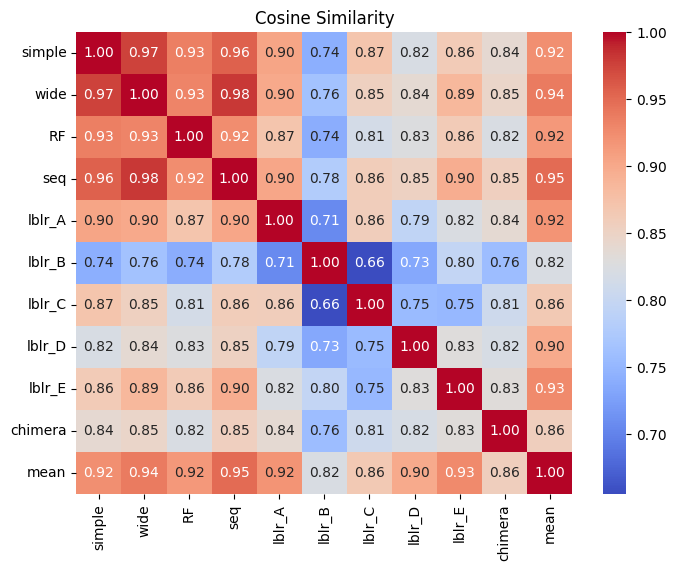

In [73]:
# Compute Cosine similarity

cosine_sim = pd.DataFrame(cosine_similarity(similarity_df.T), index=similarity_df.columns, columns=similarity_df.columns)

# Plot Cosine similarity heatmap

plt.figure(figsize=(8, 6))
sns.heatmap(cosine_sim.astype(float), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cosine Similarity")
plt.show()

In [74]:
from sklearn.decomposition import PCA

# Use PCA for dimensionality reduction to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(cosine_sim.T)

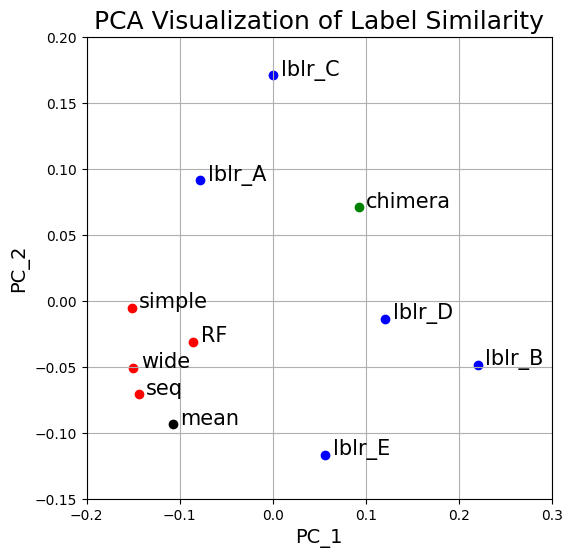

In [98]:
# Plot the 2D representation
plt.figure(figsize=(6, 6))

# Plot the first 5 points in a different color
plt.scatter(pca_result[:4, 0], pca_result[:4, 1], color='red', label='Models')
plt.scatter(pca_result[4:9, 0], pca_result[4:9, 1], color='blue', label='Labelers')
plt.scatter(pca_result[-2, 0], pca_result[-2, 1], color='green', label='Chimera')
plt.scatter(pca_result[-1, 0], pca_result[-1, 1], color='black', label='Loo mean')

# Annotate the points with column names
for i, column in enumerate(similarity_df.columns):
    plt.annotate(column, (pca_result[i, 0]+0.008, pca_result[i, 1]), fontsize=15)

plt.title("PCA Visualization of Label Similarity", fontsize=18)
plt.xlabel("PC_1", fontsize=14)
plt.ylabel("PC_2", fontsize=14)
plt.grid(True)
# plt.xlim((-0.2, 0.3))
# plt.ylim((-0.15, 0.2))
plt.show()

In [77]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Transpose the DataFrame to analyze columns
df_transposed = ((similarity_df >= 0.5).astype(int)).T

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_transposed)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Add the principal components to the original DataFrame
df_pca = pd.concat([df_transposed.reset_index(), pca_df], axis=1)

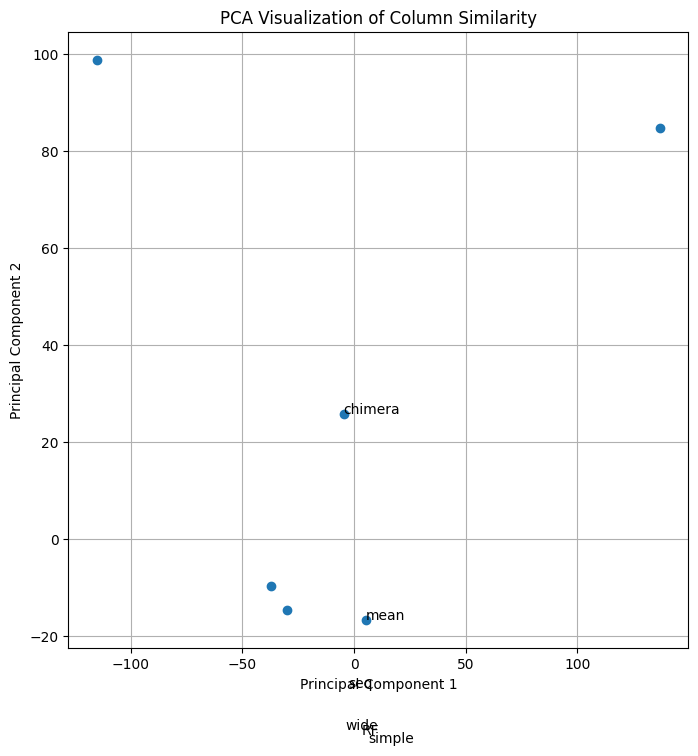

Explained variance ratio: [0.27439644 0.1840997 ]


In [78]:
# Plot the principal components
plt.figure(figsize=(8, 8))

"""
# Plot the first 5 points in a different color
plt.scatter(pca_df['PC1'][:5], pca_df['PC2'][:5], color='red', label='Tresholds')
plt.scatter(pca_df['PC1'][5:8], pca_df['PC2'][5:8], color='blue', label='Models')
plt.scatter(pca_df['PC1'][8:13], pca_df['PC2'][8:13], color='green', label='Labelers')
plt.scatter(pca_df['PC1'][13], pca_df['PC2'][13], color='black', label='Geometric')
plt.scatter(pca_df['PC1'][14], pca_df['PC2'][14], color='black', label='Mean')

for i in range(len(pca_df)):
        plt.text(pca_df['PC1'][i], pca_df['PC2'][i], df_transposed.index[i])
"""

plt.scatter(pca_df['PC1'][5:18], pca_df['PC2'][5:18])

for i in range(len(pca_df)):
        if df_transposed.index[i] in ['simple', 'wide', 'RF', 'seq', 'A', 'B', 'C', 'D', 'E', 'chimera', 'mean', 'int_mean', 'geometric']:
                plt.text(pca_df['PC1'][i], pca_df['PC2'][i], df_transposed.index[i])

plt.title("PCA Visualization of Column Similarity")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

# Print explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)

Now we can use the models in an example video

In [79]:
# Prepare the dataset of a video we want to analyze and see
X_view = pd.read_csv(os.path.join(STORM_folder, 'example/Example_position.csv')).filter(regex='^(?!.*tail)')
video_path = os.path.join(STORM_folder, 'example/Example_video.mp4')

labels_A = pd.read_csv(os.path.join(STORM_folder, 'example/Example_Marian.csv'))
labels_B = pd.read_csv(os.path.join(STORM_folder, 'example/Example_Agus.csv'))
labels_C = pd.read_csv(os.path.join(STORM_folder, 'example/Example_Santi.csv'))
labels_D = pd.read_csv(os.path.join(STORM_folder, 'example/Example_Guille.csv'))
labels_E = pd.read_csv(os.path.join(STORM_folder, 'example/Example_Dhers.csv'))

dfs_example = [labels_A, labels_B, labels_C, labels_D, labels_E]

# Calculate average labels
sum_df_example = pd.DataFrame()
for df in dfs_example:
    sum_df_example = sum_df_example.add(df, fill_value=0)
avrg_example = sum_df_example / len(dfs_example)

In [80]:
autolabels_simple = use_model(X_view, model_simple)
autolabels_wide = use_model(X_view, model_wide, reshaping = True)
autolabels_RF = use_model(X_view, RF_model)
autolabels_seq = use_model(X_view, model_seq, reshaping = True)

469/469 [==============================] - 2s 4ms/step


c:\Users\dhers\miniconda3\envs\storm\lib\site-packages\sklearn\base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



469/469 [==============================] - 3s 7ms/step


In [105]:
import plotly.graph_objects as go

# Create a time axis (frame number divided by frame rate gives time in seconds)
time = np.arange(len(autolabels_simple["obj_1"])) / 25

# Create a figure
fig = go.Figure()

# Add traces for each label set
fig.add_trace(go.Scatter(x=time, y=[x * 1.025 for x in labels_A["obj_1"]], mode='markers', name='lblr_A', marker=dict(color='magenta')))
fig.add_trace(go.Scatter(x=time, y=[x * 1.05 for x in labels_B["obj_1"]], mode='markers', name='lblr_B', marker=dict(color='cyan')))
fig.add_trace(go.Scatter(x=time, y=[x * 1.075 for x in labels_C["obj_1"]], mode='markers', name='lblr_C', marker=dict(color='orange')))
fig.add_trace(go.Scatter(x=time, y=[x * 1.10 for x in labels_D["obj_1"]], mode='markers', name='lblr_D', marker=dict(color='purple')))
fig.add_trace(go.Scatter(x=time, y=[x * 1.125 for x in labels_E["obj_1"]], mode='markers', name='lblr_E', marker=dict(color='black')))

# fig.add_trace(go.Scatter(x=list(range(len(avrg_example["obj_1"]))), y=avrg_example["obj_1"], mode='lines', name='Average', line=dict(color='black')))

fig.add_trace(go.Scatter(x=time, y=autolabels_simple["obj_1"], mode='lines', name='Simple', line=dict(color='green', width=2)))
fig.add_trace(go.Scatter(x=time, y=autolabels_wide["obj_1"], mode='lines', name='Wide', line=dict(color='blue', width=2)))
# fig.add_trace(go.Scatter(x=list(range(len(autolabels_RF["obj_1"]))), y=autolabels_RF["obj_1"], mode='lines', name='RF', line=dict(color='gray', width=2)))
fig.add_trace(go.Scatter(x=time, y=autolabels_seq["obj_1"], mode='lines', name='Sequential', line=dict(color='red', width=3)))

# Add horizontal lines
fig.add_hline(y=0.5, line_dash="dash", line_color="black")

# Update layout
fig.update_layout(
title=dict(
        text=f'Performance of the models',
        x=0.5,
        y=0.95,
        xanchor='center',
        xref='paper'),
xaxis_title="Time (s)",
yaxis_title="Model output",
legend=dict(yanchor="bottom", y=0.35, xanchor="left", x=0.2),  # Position the legend above the plot
#yaxis=dict(range=[None, 1.2]),
xaxis=dict(range=[130, 144]),
margin=dict(t=60, b=20, l=20, r=20),
showlegend=True,
width=720,
height=480,
font=dict(size=18)
)

# Show the plot
fig.show()